# STEM probe overlap

This notebook demonstrates how using simulation cells that are too small (or PRISM interpolation factors which are too large) can lead to unphysical "self-interaction" of a converged STEM probe.  This is due to the impliciy (x,y)-plane periodicity assumed in the simulation.  These wraparound artifacts are also an issue for HRTEM simulations - howeever, because these simulations run much faster, we can more easily increase the cell dimensions.

TODO - implement abTEM probe methods?

In [1]:
from abtem import *
from abtem.visualize import show_atoms

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d
from matplotlib.colors import LightSource
from matplotlib import cm
import matplotlib.patches as mpatches

In [83]:
# Function to draw probe overlap comparisons

def probe_overlap(
    cell_dim = np.array([20, 20, 50]),
    probe_semiangle_mrads = 30,
    probe_defocus = 0,
    probe_C3 = 0,
    PRISM_interp_factor = [1,1],
    wavelength = 0.02,
    proj_dir = [30,15],
    figsize = [18,4],
    plot_3D_limit_scale = 1.0,
    returnfig = False,
):

    """
    STEM probe overlap figure function. We assume the sign of defocus is -1*C_1, i.e. if we defocus to +10 Angstoms,
    the probe crossover will be +10 Angstroms into the sample - i.e. we apply -10 Angstroms C_1.

    Args:
        cell_dim (float):           3 element vector containing cell dimensions
        probe_semiangle_mrads (float): STEM probe semiangle in millirads
        probe_defocus (float):  defocus of the STEM probe, opposite sign as C1, in untis of Angstroms
        probe_C3 (float):       spherical aberration of the probe in Angstroms
        PRISM_interp_factor (int):  the 2 integer interpolation factors
        wavelength (float):    wavelength of electrons in Angstroms
        proj_dir (float):           3D frame projection direction, either [elev,azim] or [u,v,w] normal vector
        figsize (2 element float):  size of the figure frame
        returnfig (bool):           set to True to return figure and axes handles

    Returns:
        fig, ax                     (optional) figure and axes handles
    """
    
    # Hard coded inputs
    image_size_pixels = np.array([256,256])
    scale_factor_ideal = 4
    # cmap = 'gray'
    # cmap = 'inferno'
    cmap = 'turbo'
    aspect_ratio = cell_dim[1]/cell_dim[0]
    
    # Scale pixel size to accomodate PRISM factor
    image_size_pixels[0] = np.round(image_size_pixels[0]/PRISM_interp_factor[0]/2.0)*PRISM_interp_factor[0]*2
    image_size_pixels[1] = np.round(image_size_pixels[1]/PRISM_interp_factor[1]/2.0)*PRISM_interp_factor[1]*2
    
    # Get azimuthal and elevation angles
    if np.size(proj_dir) == 2:
            el = proj_dir[0]
            az = proj_dir[1]
    elif np.size(proj_dir) == 3:
        if proj_dir[0] == 0 and proj_dir[1] == 0:
            el = 90 * np.sign(proj_dir[2])
        else:
            el = (
                np.arctan(
                    proj_dir[2] / np.sqrt(proj_dir[0] ** 2 + proj_dir[1] ** 2)
                )
                * 180
                / np.pi
            )
        az = np.arctan2(proj_dir[1], proj_dir[0]) * 180 / np.pi
    else:
        raise Exception(
            "Projection direction cannot contain " + np.size(proj_dir) + " elements"
        )
    
    
    # unit cell geometry
    u = np.array([cell_dim[0],0,0])
    v = np.array([0,cell_dim[1],0])
    w = np.array([0,0,cell_dim[2]])
    p = np.vstack([[0, 0, 0], u, u + v, v, w, u + w, u + v + w, v + w])
    #     p = p[:, [1, 0, 2]]  # Reorder cell boundaries
    f = np.array(
        [
            [0, 1, 2, 3],
            [4, 5, 6, 7],
            [0, 1, 5, 4],
            [2, 3, 7, 6],
            [0, 3, 7, 4],
            [1, 2, 6, 5],
        ]
    )
    
    # Probe geometry
    alpha = probe_semiangle_mrads / 1000 
    dist_top = cell_dim[2]*-0.25
    radius_top = (-probe_defocus + dist_top) * np.tan(alpha)
    radius_entrance = -probe_defocus * np.tan(alpha)
    radius_exit = (-probe_defocus + cell_dim[2]) * np.tan(alpha)
    if np.abs(radius_entrance) > np.abs(radius_exit):
        C1_max = -probe_defocus
    else:
        C1_max = -probe_defocus + cell_dim[2]
    
    # Probe vertices
    # t = np.linspace(0,2*np.pi,180+1,endpoint=True)
    t = np.linspace(-np.pi, np.pi, 180+1, endpoint=True)
    z = np.array([0, cell_dim[2], cell_dim[2]-dist_top])
    ta,za = np.meshgrid(t,z)
    ra = (za + probe_defocus - cell_dim[2]) * np.tan(alpha)
    xa = ra * np.cos(ta) + cell_dim[0]/2.0
    ya = ra * np.sin(ta) + cell_dim[1]/2.0    
    
    
    # Probe images
    q_probe = alpha / wavelength
    
    # actual coordinates
    pixel_size = cell_dim[0:2] / image_size_pixels
    qx = np.fft.fftfreq(image_size_pixels[0],pixel_size[0])
    qy = np.fft.fftfreq(image_size_pixels[1],pixel_size[1])
    qya,qxa = np.meshgrid(qy,qx)
    qra2 = qxa**2 + qya**2
    probe_mask = qra2 <= q_probe**2
    if probe_C3 == 0:
        Psi = probe_mask * np.exp(-1j*(
            np.pi*wavelength*C1_max*qra2))
    else:
        Psi = probe_mask * np.exp(-1j*(
            np.pi*wavelength*C1_max*qra2 + (np.pi/2)*wavelength**3*probe_C3*qra2**2))
    
    # apply PRISM interpolation factor in Fourier space
    if PRISM_interp_factor[0] > 1:
        Psi[PRISM_interp_factor[0]-1::PRISM_interp_factor[0],:] = 0
    if PRISM_interp_factor[1] > 1:
        Psi[:,PRISM_interp_factor[1]-1::PRISM_interp_factor[1]] = 0

    psi = np.fft.ifft2(Psi)

    # apply PRISM interpolation factor in real space
    if PRISM_interp_factor[0] > 1:
        ind0 = (image_size_pixels[0]/PRISM_interp_factor[0]/2).astype('int')
        ind1 = (image_size_pixels[0]-image_size_pixels[0]/PRISM_interp_factor[0]/2).astype('int')
        psi[ind0:ind1,:] = 0
    if PRISM_interp_factor[1] > 1:
        ind0 = (image_size_pixels[1]/PRISM_interp_factor[1]/2).astype('int')
        ind1 = (image_size_pixels[1]-image_size_pixels[1]/PRISM_interp_factor[1]/2).astype('int')
        psi[:,ind0:ind1] = 0
        
    # Normalize
    Psi = np.fft.fft2(psi)
    Psi = Psi / np.sqrt(np.sum(np.abs(Psi)**2))
    psi =  np.fft.ifft2(Psi)
    
    # scaled up coordinates for ideal image
    qx = np.fft.fftfreq(scale_factor_ideal * image_size_pixels[0],pixel_size[0])
    qy = np.fft.fftfreq(scale_factor_ideal * image_size_pixels[1],pixel_size[1])
    qya_ideal,qxa_ideal = np.meshgrid(qy,qx)
    qra2_ideal = qxa_ideal**2 + qya_ideal**2
    probe_mask_ideal = qra2_ideal <= q_probe**2
    if probe_C3 == 0:
        Psi_ideal = probe_mask_ideal * np.exp(-1j*(
            np.pi*wavelength*C1_max*qra2_ideal))
    else:
        Psi_ideal = probe_mask_ideal * np.exp(-1j*(
            np.pi*wavelength*C1_max*qra2_ideal + (np.pi/2)*wavelength**3*probe_C3*qra2_ideal**2))
    # Normalize
    Psi_ideal = Psi_ideal / np.sqrt(np.sum(np.abs(Psi_ideal)**2))
    Psi_ideal = Psi_ideal * scale_factor_ideal
    # Real space
    psi_ideal = np.fft.ifft2(Psi_ideal)   
    # crop down to the actual coordinates
    x_inds = (np.hstack((np.arange(0,image_size_pixels[0]/2),
                        np.arange(scale_factor_ideal * image_size_pixels[0]-image_size_pixels[0]/2,scale_factor_ideal * image_size_pixels[0])))).astype('int')
    y_inds = (np.hstack((np.arange(0,image_size_pixels[1]/2),
                        np.arange(scale_factor_ideal * image_size_pixels[1]-image_size_pixels[1]/2,scale_factor_ideal * image_size_pixels[1])))).astype('int')
    psi_ideal = psi_ideal[x_inds[:,None],y_inds[None,:]]
    
    # Shift images
    psi = np.fft.fftshift(psi)
    psi_ideal = np.fft.fftshift(psi_ideal)
        
    # Scale bar
    leng_ang = 10**round(np.log10(cell_dim[1] * 0.1))
    leng_pixels = image_size_pixels[1] * leng_ang / cell_dim[1]
    height_pixels = image_size_pixels[1] * 0.02
    
    
    
    
    
    ### PLOTTING ###
    
    # Figure layout
    ax = np.zeros((5),dtype='object') 
    fig = plt.figure(figsize=figsize)
    ax[0] = fig.add_axes(
        rect=[0.00, 0, 0.22, 1.0],
        projection="3d", 
        elev=el, 
        azim=az)
    ax[1] = fig.add_axes(
        rect=[0.24, 0, 0.22, 1.0])
    ax[2] = fig.add_axes(
        rect=[0.48, 0, 0.22, 1.0])
    ax[3] = fig.add_axes(
        rect=[0.72, 0, 0.22, 1.0])
    ax[4] = fig.add_axes(
        rect=[0.96, 0, 0.02, 1.0])    
    
    # Draw 3D scene
    # Cell boundaries
    pc = art3d.Poly3DCollection(
        p[f],
        facecolors=[0.7, 0.9, 1],
        edgecolor=[0, 0, 0],
        linewidth=2,
        alpha=0.1,
    )
    ax[0].add_collection(pc)
    plot_limit = np.array(
        [
            [np.min(p[:, 0]), np.min(p[:, 1]), np.min(p[:, 2])],
            [np.max(p[:, 0]), np.max(p[:, 1]), np.max(p[:, 2])],
        ]
    )
    plot_limit = (plot_limit - np.mean(plot_limit, axis=0)) * plot_3D_limit_scale + np.mean(
        plot_limit, axis=0
    )
    # Probe
    # light = LightSource(90, 45)
    light = LightSource(15, 125)
    #illuminated_surface = light.shade(ta, cmap=cm.coolwarm)    
    rgb = np.ones((xa.shape[0], xa.shape[1], 3))
    #     illuminated_surface = light.shade_rgb(rgb, xa)
    green = np.array([0,1.0,0])
    green_surface = light.shade_rgb(rgb * green, xa)
    ax[0].plot_surface(
        xa, 
        ya, 
        za,
        alpha=0.4,
        linewidth=0,
        antialiased=True,
        facecolors=green_surface)
    r0 = 1 * wavelength / alpha
    r1 = r0 + np.abs(radius_exit)
    r2 = r0 + np.abs(radius_entrance)
    if np.abs(radius_entrance) > np.abs(radius_exit):
        ax[0].plot(
            cell_dim[0]/2.0 + r1*np.cos(t),
            cell_dim[1]/2.0 + r1*np.sin(t),
            np.zeros_like(t),
            color='k',
            linewidth=3)
        ax[0].plot(
            cell_dim[0]/2.0 + r2*np.cos(t),
            cell_dim[1]/2.0 + r2*np.sin(t),
            cell_dim[2] + np.zeros_like(t),
            color='r',
            linewidth=3)
    else:
        ax[0].plot(
            cell_dim[0]/2.0 + r1*np.cos(t),
            cell_dim[1]/2.0 + r1*np.sin(t),
            np.zeros_like(t),
            color='r',
            linewidth=3)
        ax[0].plot(
            cell_dim[0]/2.0 + r2*np.cos(t),
            cell_dim[1]/2.0 + r2*np.sin(t),
            cell_dim[2] + np.zeros_like(t),
            color='k',
            linewidth=3)
    
    # appearance
    ax[0].axes.set_xlim3d(left=plot_limit[0, 1], right=plot_limit[1, 0])
    ax[0].axes.set_ylim3d(bottom=plot_limit[0, 0], top=plot_limit[1, 1])
    ax[0].axes.set_zlim3d(bottom=plot_limit[0, 2], top=plot_limit[1, 2])
    ax[0].set_box_aspect((1, 1, 1))
    ax[0].set_axis_off()
    #     ax[0].invert_yaxis()
    #     ax[0].set_box_aspect((1,1,1))
    axisEqual3D(ax[0])
        
    
    # Plot probe images
    im = np.abs(psi)
    im_ideal = np.abs(psi_ideal) 
    scale = np.max(im)
    # scale = np.max(im_ideal)
    im = im / scale
    im_ideal = im_ideal / scale
    im_diff = np.abs(im - im_ideal)
    #     c_range = np.array([0, np.max(im_ideal)])
    d_range = np.array([0, np.max(im_diff)])
    ax[1].imshow(
        im,
        cmap=cmap,
        vmin=0,
        vmax=1)
    ax[2].imshow(
        im_ideal,
        cmap=cmap,
        vmin=0,
        vmax=1)
    ax[3].imshow(
        im_diff,
        cmap=cmap,
        vmin=d_range[0],
        vmax=d_range[1])
        
    # other appearance stuff
    ax[1].set_axis_off()
    ax[2].set_axis_off()
    ax[3].set_axis_off()
    forceAspect(ax[1],aspect_ratio)
    forceAspect(ax[2],aspect_ratio)
    forceAspect(ax[3],aspect_ratio)
    ax[1].set_title('Simulated Probe Amplitude', fontsize=18)
    ax[2].set_title('Ideal Probe Amplitude', fontsize=18)
    ax[3].set_title('Absolute Error of Probe', fontsize=18)
    
    # intensity legend    
    im_leg = np.linspace(d_range[0],d_range[1],256)
    ax[4].imshow(
        im_leg[:,None],
        cmap=cmap,
        aspect='auto',
        vmin=d_range[0],
        vmax=d_range[1])
    ax[4].invert_yaxis()
    ax[4].set_xticks([])
    ax[4].yaxis.tick_right()
    ax[4].set_yticks([0,255])
    ax[4].set_yticklabels(['0', str(float('%.1g' % (100*d_range[1]))) + '%'])
    ax[4].set_ylabel('Error Relative to Max Probe Amplitude', fontsize=14)
    ax[4].yaxis.set_label_position("right")

    # Add scale bar
    rect=mpatches.Rectangle(
        (image_size_pixels[0]*0.05, image_size_pixels[1]*0.95 - height_pixels),
        leng_pixels,
        height_pixels, 
        fill=True,
        linewidth=0,
        facecolor="w")
    ax[1].add_patch(rect)
    ax[1].text(
        image_size_pixels[0]*0.05 + leng_pixels/2.0,
        image_size_pixels[1]*0.93 - height_pixels,
        str(leng_ang) + ' A',
        color='w',
        fontsize=18,
        ha='center',
    )
    
    
    # Draw figure, output axes if needed
    plt.show()   
    if returnfig:
        return fig, ax

    
# Trying another solution to make axes equal in 3D
def axisEqual3D(ax):
    extents = np.array([getattr(ax, "get_{}lim".format(dim))() for dim in "xyz"])
    sz = extents[:, 1] - extents[:, 0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize / 2
    for ctr, dim in zip(centers, "xyz"):
        getattr(ax, "set_{}lim".format(dim))(ctr - r, ctr + r)
        
def forceAspect(ax,aspect=1):
    im = ax.get_images()
    extent =  im[0].get_extent()
    ax.set_aspect(abs((extent[1]-extent[0])/(extent[3]-extent[2]))/aspect)

# Geometric tests for cell dimensions

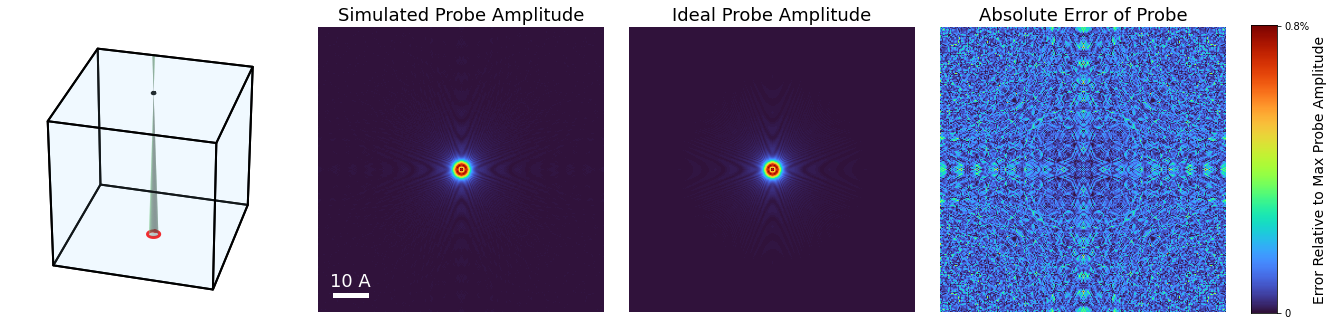

In [84]:
probe_overlap(
    cell_dim=np.array([80,80,80]),
    probe_semiangle_mrads = 30,
    probe_defocus = 0,
    plot_3D_limit_scale = 1.0)

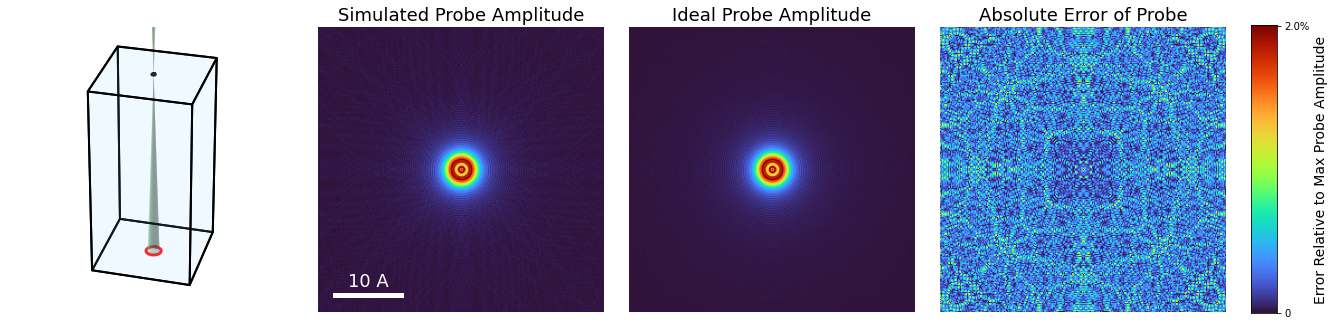

In [50]:
probe_overlap(
    cell_dim=np.array([40,40,80]),
    probe_semiangle_mrads = 30,
    probe_defocus = 0,
    plot_3D_limit_scale = 0.8)

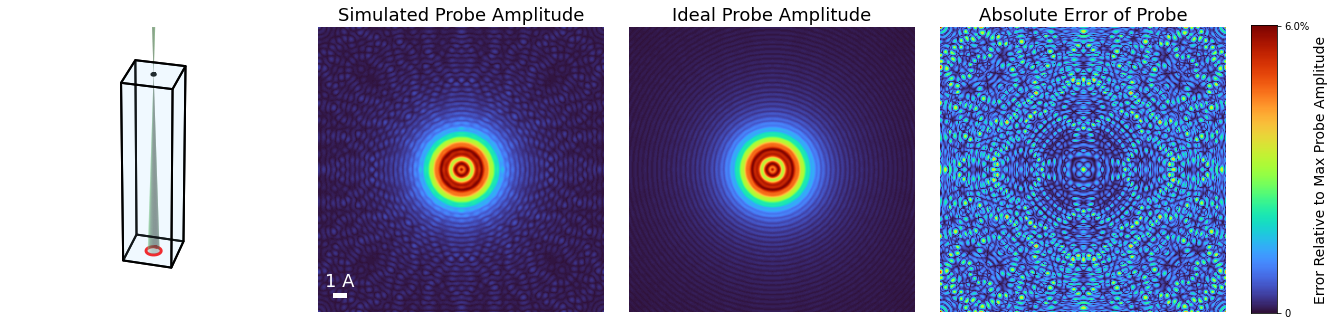

In [51]:
probe_overlap(
    cell_dim=np.array([20,20,80]),
    probe_semiangle_mrads = 30,
    probe_defocus = 0,
    plot_3D_limit_scale = 0.8)

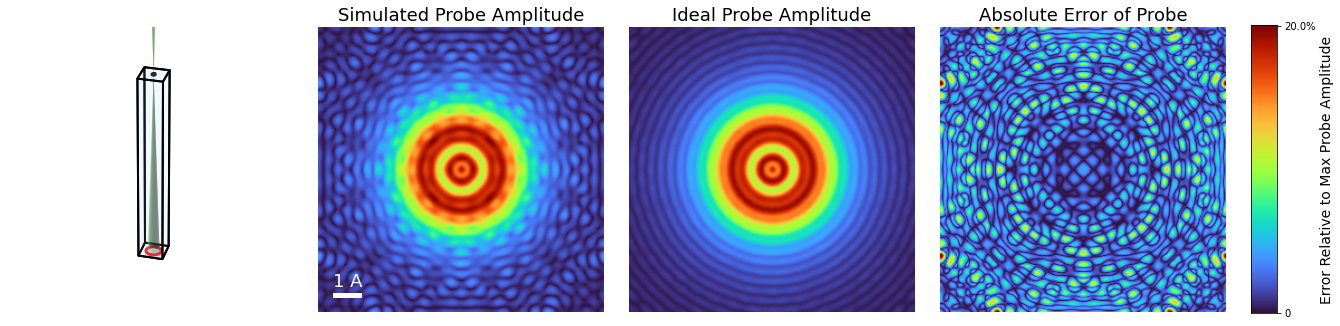

In [52]:
probe_overlap(
    cell_dim=np.array([10,10,80]),
    probe_semiangle_mrads = 30,
    probe_defocus = 0,
    plot_3D_limit_scale = 0.8)

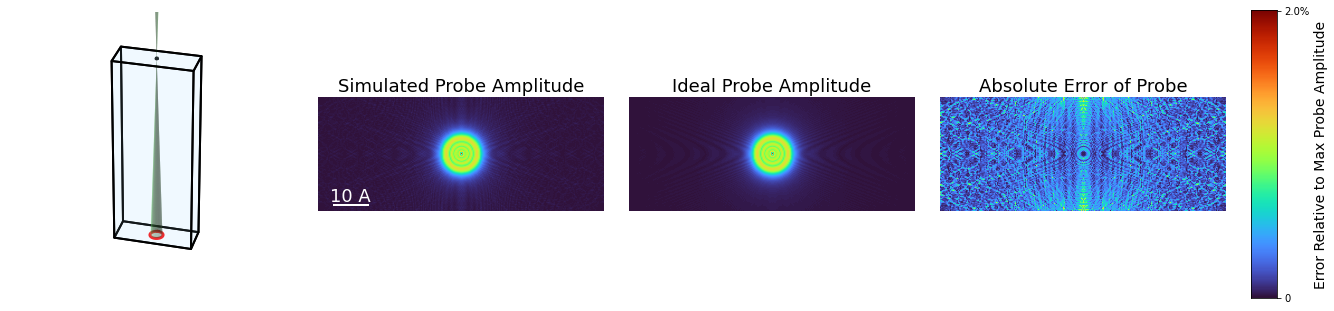

In [106]:
probe_overlap(
    cell_dim=np.array([32,80,200]),
    probe_semiangle_mrads = 30,
    probe_defocus = 0,
    plot_3D_limit_scale = 0.8)

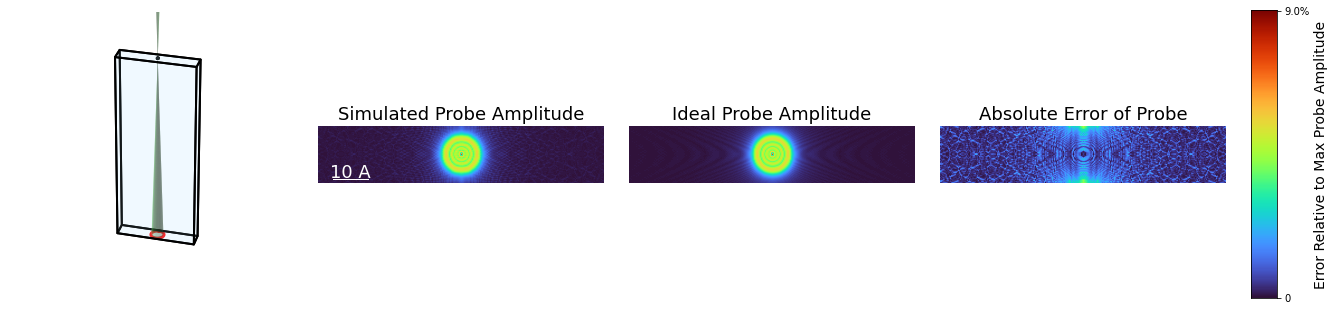

In [107]:
probe_overlap(
    cell_dim=np.array([16,80,200]),
    probe_semiangle_mrads = 30,
    probe_defocus = 0,
    plot_3D_limit_scale = 0.8)

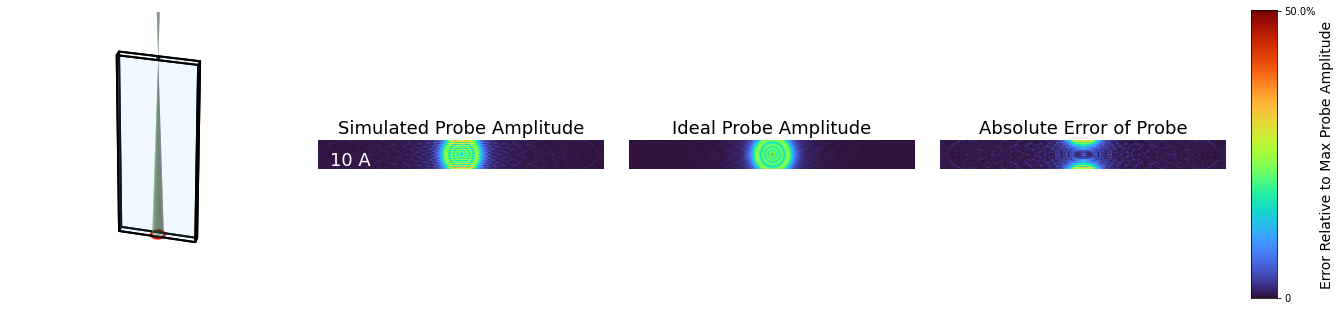

In [108]:
probe_overlap(
    cell_dim=np.array([8,80,200]),
    probe_semiangle_mrads = 30,
    probe_defocus = 0,
    plot_3D_limit_scale = 0.8)

# Probe defocus

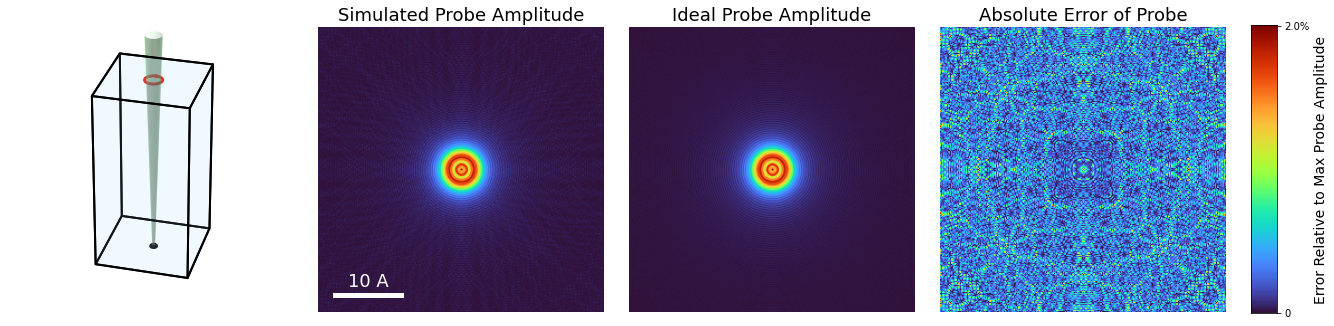

In [72]:
probe_overlap(
    cell_dim=np.array([40,40,80]),
    probe_semiangle_mrads = 30,
    probe_defocus = 100,
    plot_3D_limit_scale = 0.85)

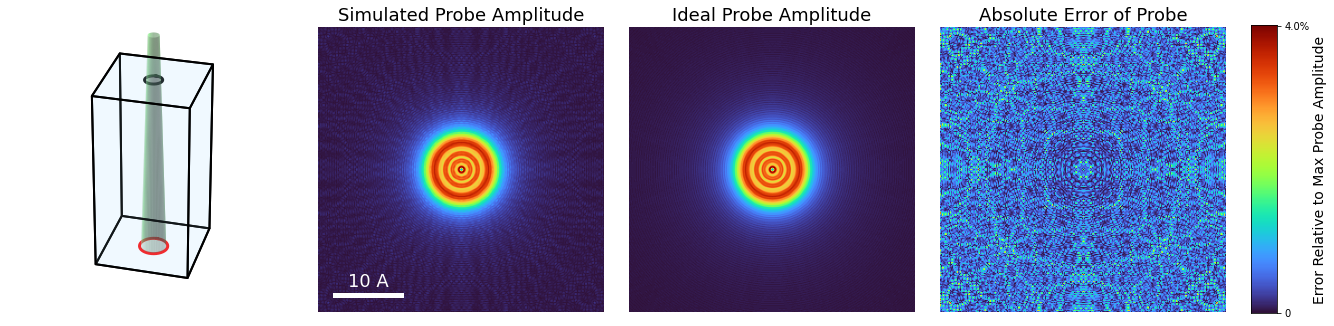

In [73]:
probe_overlap(
    cell_dim=np.array([40,40,80]),
    probe_semiangle_mrads = 30,
    probe_defocus = -100,
    plot_3D_limit_scale = 0.85)

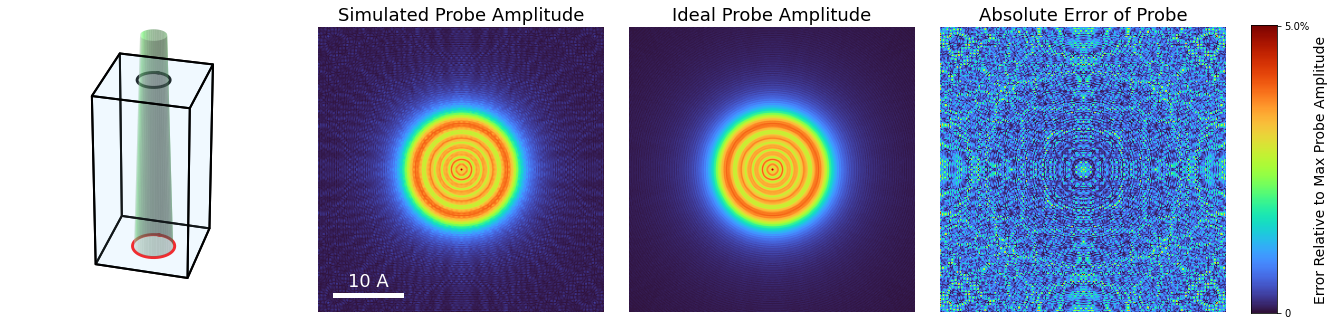

In [74]:
probe_overlap(
    cell_dim=np.array([40,40,80]),
    probe_semiangle_mrads = 30,
    probe_defocus = -200,
    plot_3D_limit_scale = 0.85)

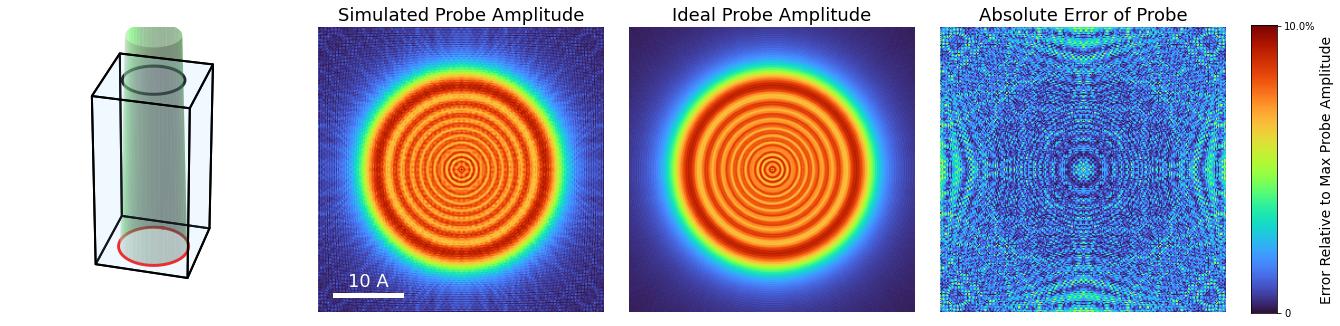

In [75]:
probe_overlap(
    cell_dim=np.array([40,40,80]),
    probe_semiangle_mrads = 30,
    probe_defocus = -400,
    plot_3D_limit_scale = 0.85)

# PRISM interpolation

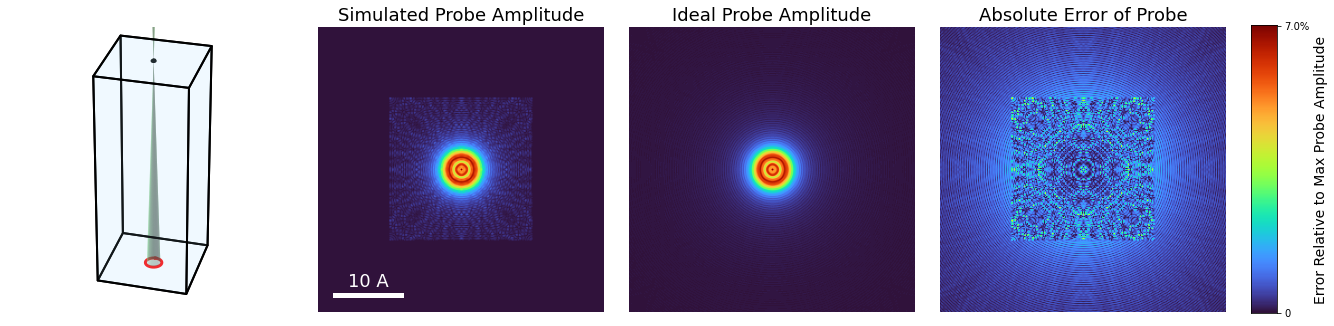

In [76]:
fig, ax = probe_overlap(
    cell_dim=np.array([40,40,100]),
    probe_semiangle_mrads = 30,
    probe_defocus = 0,
    PRISM_interp_factor = [2,2],
    plot_3D_limit_scale = 0.7,
    returnfig = True)

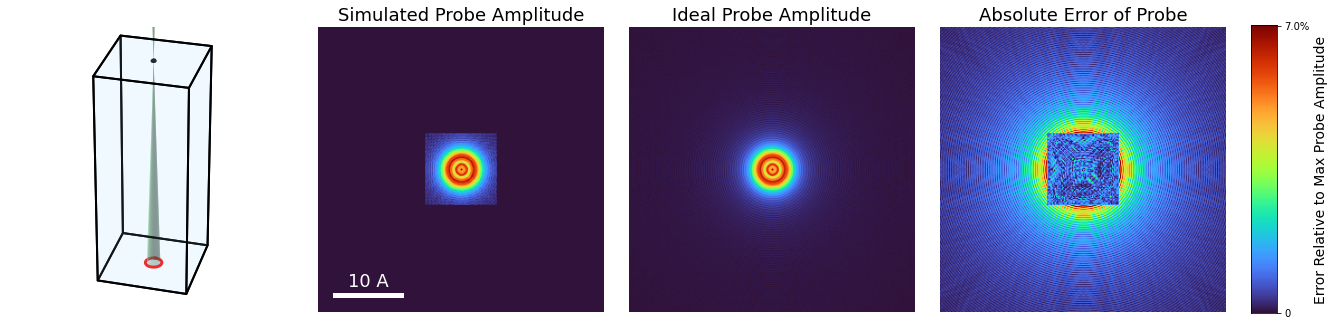

In [77]:
fig, ax = probe_overlap(
    cell_dim=np.array([40,40,100]),
    probe_semiangle_mrads = 30,
    probe_defocus = 0,
    PRISM_interp_factor = [4,4],
    plot_3D_limit_scale = 0.7,
    returnfig = True)

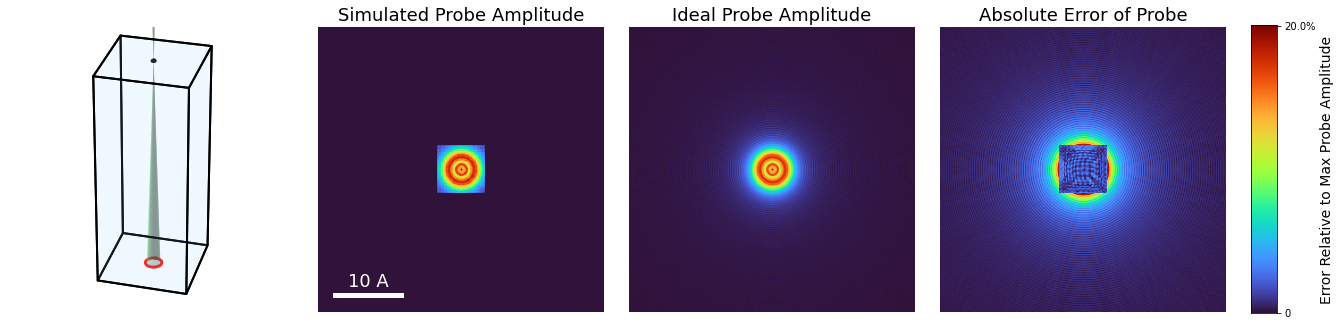

In [80]:
fig, ax = probe_overlap(
    cell_dim=np.array([40,40,100]),
    probe_semiangle_mrads = 30,
    probe_defocus = 0,
    PRISM_interp_factor = [6,6],
    plot_3D_limit_scale = 0.7,
    returnfig = True)

# Spherical aberration

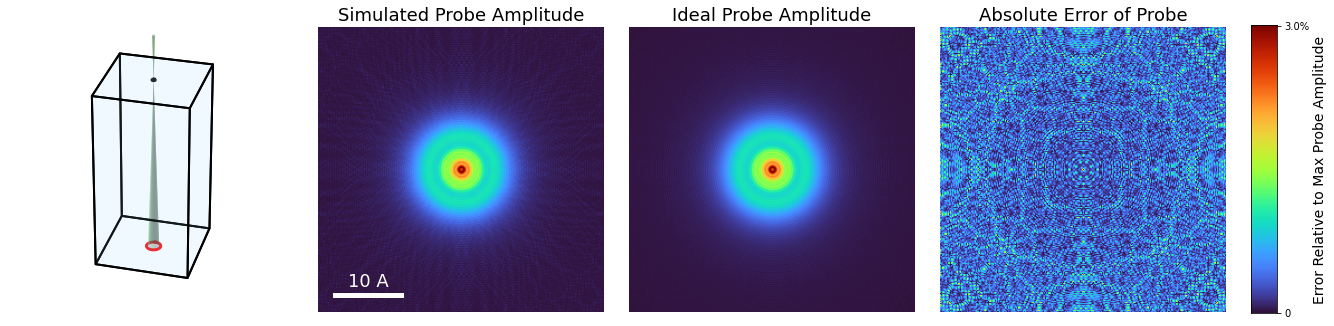

In [96]:
probe_overlap(
    cell_dim=np.array([40,40,80]),
    probe_semiangle_mrads = 30,
    probe_C3=2e5,
    probe_defocus = 0,
    plot_3D_limit_scale = 0.85)

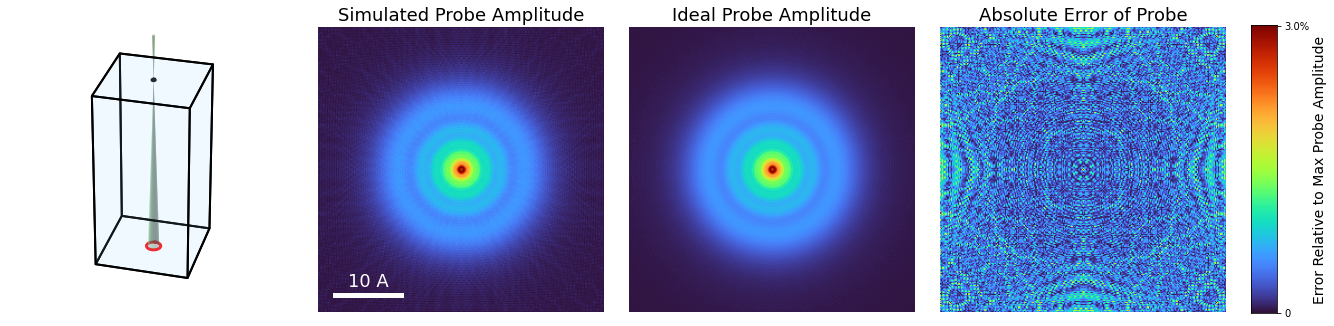

In [97]:
probe_overlap(
    cell_dim=np.array([40,40,80]),
    probe_semiangle_mrads = 30,
    probe_C3=4e5,
    probe_defocus = 0,
    plot_3D_limit_scale = 0.85)

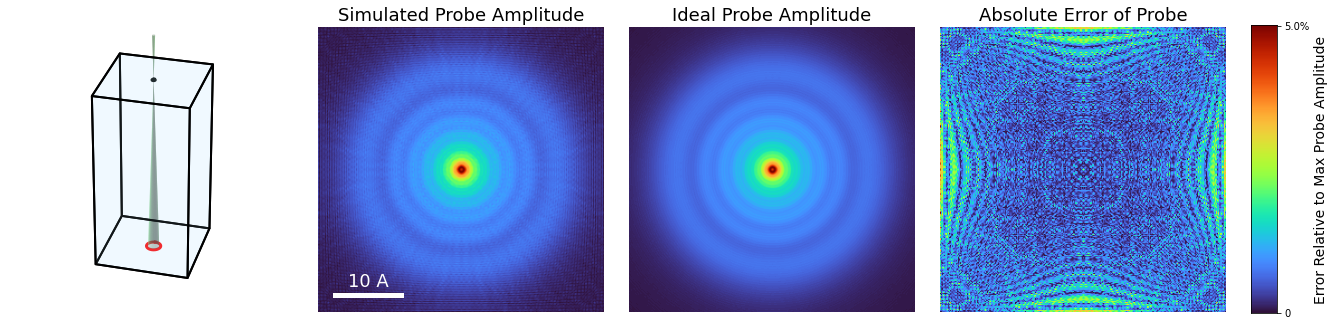

In [99]:
probe_overlap(
    cell_dim=np.array([40,40,80]),
    probe_semiangle_mrads = 30,
    probe_C3=6e5,
    probe_defocus = 0,
    plot_3D_limit_scale = 0.85)